## Introduction to Image Processing with Python
### Image Processing (RM1-VIS)
### University of Southern Denmark

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

In [3]:
def plotImage(image, title):
    if(len(image.shape) == 2):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Super-Pixels



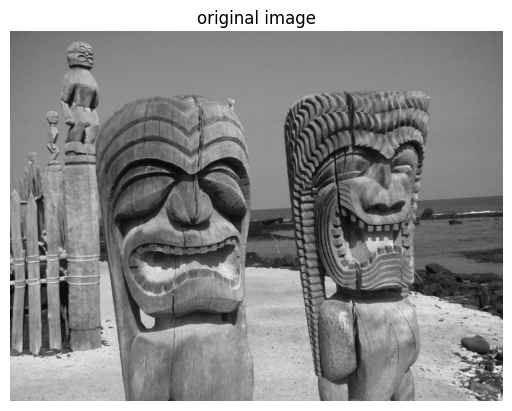

In [4]:
image = skimage.io.imread('totem-poles.tif')
plotImage(image, "original image")

Implement SLIC and show the superpixel segmentation of the image above for ca. 10000, 1000, and 100 super-pixels. 
* A suitable convergence threshold should be found from experimentation.
* The modified distance measure (normalizing rgb and xy) should be used.
* Cluster centers should be initialized on a regular grid in the image.
* Visualize both the clean super-pixel clustered results and the results with highlighted boundaries (as in GW Fig. 10.50 middle) 

C:\Users\HP\AppData\Local\Temp\ipykernel_19464\3726466654.py:50: RuntimeWarning: overflow encountered in scalar subtract
  dc = (image[int(cy),int(cx)] - image[y, x]) ** 2


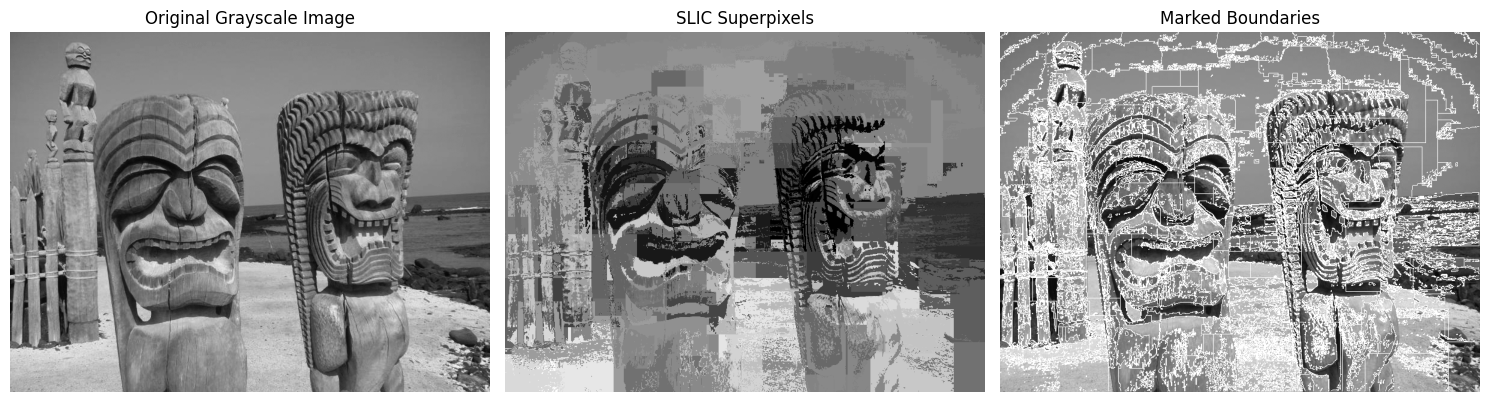

In [5]:


def calculate_gradient(image):
    # Pad the image to handle the borders
    padded_image = np.pad(image, 1, mode='reflect')
    
    # Calculate gradients in the x and y directions
    gradient_x = padded_image[1:-1, :-2] - padded_image[1:-1, 2:]
    gradient_y = padded_image[:-2, 1:-1] - padded_image[2:, 1:-1]
    
    # Calculate the magnitude of the gradient
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    return gradient_magnitude

def find_lowest_gradient(gradient_magnitude, center):
    y, x = center
    # Define the 3x3 neighborhood
    y_start, y_end = max(y - 1, 0), min(y + 2, gradient_magnitude.shape[0])
    x_start, x_end = max(x - 1, 0), min(x + 2, gradient_magnitude.shape[1])
    # Find the position of the lowest gradient in the neighborhood
    neighborhood = gradient_magnitude[y_start:y_end, x_start:x_end]
    min_pos = np.unravel_index(np.argmin(neighborhood), neighborhood.shape)
    # Adjust the position relative to the entire image
    new_y, new_x = min_pos[0] + y_start, min_pos[1] + x_start
    return new_y, new_x

def initialize_centers(image, K):
    H, W = image.shape
    S = int(np.sqrt(H * W / K))
    stepY, stepX = int(np.sqrt(K)), int(np.sqrt(K))
    centers = [(int(h), int(w)) for h in np.linspace(S//2, H - S//2, stepY, endpoint=False)
                                 for w in np.linspace(S//2, W - S//2, stepX, endpoint=False)]
    return np.array(centers)

def assign_pixels_to_centers(image, centers, S, c):
    H, W = image.shape
    distances = np.full((H, W), np.inf, dtype=float)
    labels = -np.ones((H, W), dtype=int)
    
    for i, center in enumerate(centers):
        cy, cx = center
        for dy in range(-S, S+1):
            for dx in range(-S, S+1):
                y, x = int(cy + dy), int(cx + dx)
                if 0 <= y < H and 0 <= x < W:
                    dc = (image[int(cy),int(cx)] - image[y, x]) ** 2
                    ds = dy ** 2 + dx ** 2
                    D = np.sqrt(dc + (ds / S ** 2) * c ** 2)
                    if D < distances[y, x]:
                        distances[y, x] = D
                        labels[y, x] = i
    return labels



def update_cluster_centers(image, labels, K):
    new_centers = []
    for k in range(K):
        # Extract the pixels belonging to the current superpixel
        cluster_pixels = np.argwhere(labels == k)
        if cluster_pixels.size > 0:
            # Calculate the mean position of all pixels within the superpixel
            mean_position = np.mean(cluster_pixels, axis=0)
            new_centers.append(mean_position)
        else:
            # If no pixels were assigned to the superpixel, set the center to (0, 0)
            new_centers.append((0, 0))
    
    # Ensure the new center coordinates are integers for indexing
    new_centers = np.array(new_centers, dtype=int)
    return new_centers

def slic_grayscale(image, K, c=10, num_iterations=10, convergence_threshold=1e-3):
    H, W = image.shape
    S = int(np.sqrt(H * W / K))
    centers = initialize_centers(image, K)

    # Calculate the gradient magnitude of the image
    gradient_magnitude = calculate_gradient(image)

    # Move centers to the lowest gradient position in their neighborhood
    # Ensure the centers are integers for indexing
    centers = np.array([find_lowest_gradient(gradient_magnitude, center) for center in centers]).astype(int)

    for _ in range(num_iterations):
        labels = assign_pixels_to_centers(image, centers, S, c)

        # Find the maximum label value (number of superpixels)
        max_label = np.max(labels) + 1

        # Initialize new_centers with zeros and counts for each superpixel
        new_centers = np.zeros((max_label, 2), dtype=float)
        counts = np.zeros(max_label, dtype=int)

        # Calculate the mean position of all pixels within each superpixel
        for y in range(H):
            for x in range(W):
                k = labels[y, x]
                new_centers[k, 0] += y
                new_centers[k, 1] += x
                counts[k] += 1

        # Avoid division by zero and calculate the new centers
        for k in range(max_label):
            if counts[k] > 0:
                new_centers[k, 0] /= counts[k]
                new_centers[k, 1] /= counts[k]

        # Calculate the shift of the centers to check for convergence
        center_shift = np.linalg.norm(centers - new_centers, axis=1)
        max_shift = np.max(center_shift)
        if max_shift < convergence_threshold:
            break

        centers = new_centers  # Update centers with the new_centers

    return labels, centers


# Load the image

# Run the SLIC algorithm
labels, centers = slic_grayscale(image, K=100, c=10, num_iterations=10,convergence_threshold=6)

# Create an image to visualize the segments
segmented_image = np.copy(image)
for label in np.unique(labels):
    mask = labels == label
    segmented_image[mask] = np.mean(image[mask])

# Mark the boundaries on the original image
boundary_image = np.copy(image)
for y in range(image.shape[0] - 1):
    for x in range(image.shape[1] - 1):
        if labels[y, x] != labels[y, x + 1] or labels[y, x] != labels[y + 1, x]:
            boundary_image[y, x] = np.max(image)

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.flatten()

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Grayscale Image')
ax[0].axis('off')

ax[1].imshow(segmented_image, cmap='gray')
ax[1].set_title('SLIC Superpixels')
ax[1].axis('off')

ax[2].imshow(boundary_image, cmap='gray')
ax[2].set_title('Marked Boundaries')
ax[2].axis('off')

plt.tight_layout()
plt.show()
